# Neural Style Transfer

Neural Style Transfer (NST) is an interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. 

In this experiement, Louvre museum in Paris (content image C) will be combined with the impressionist style of Claude Monet (content image S) to generate the following image:

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

# Load images

(1, 400, 400, 3)


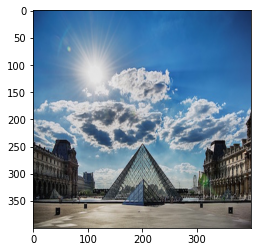

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img_size = 400

# Load content image
content_image = Image.open('images/louvre_small.jpg').resize((img_size, img_size))
content_image = np.array(content_image)
content_image = content_image / 255.
content_image = np.expand_dims(content_image, axis=0)
print(content_image.shape)

# Display content image
plt.imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


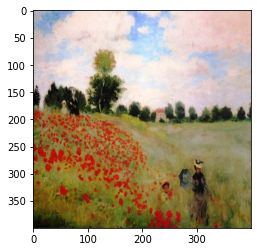

In [2]:
# Load style image
style_image = Image.open('images/monet.jpg').resize((img_size, img_size))
style_image = np.array(style_image)
style_image = style_image / 255.
style_image = np.expand_dims(style_image, axis=0)
print(style_image.shape)

# Display style image
plt.imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


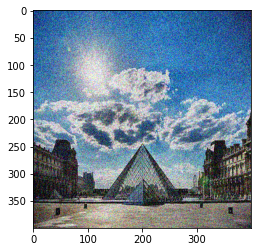

In [3]:
import tensorflow as tf

# Initialise the generated image
noise = tf.random.uniform(tf.shape(content_image), minval=-0.25, maxval=0.25)
generated_image = tf.add(noise, content_image)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0, clip_value_max=1.0)
print(generated_image.shape)

# Display generated image
plt.imshow(generated_image[0])
plt.show()

# Load model

Neural Style Transfer (NST) uses a pre-trained convolutional network, and builds on top of that. 

The pre-trained model used in this notebook is VGG19. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

In [4]:
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg.trainable = False

Listing the layer names in VGG19:

In [5]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Now, choose a set of layers and their corresponding weights to compute the <strong>style cost</strong> later

In [6]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2),
    ('block5_conv4', 1),
]

Because the overall style cost is the sum of style cost on each layer. Therefore we need to obtain the output of each layer first:

In [7]:
def get_layer_outputs(vgg, layers=STYLE_LAYERS):
    outputs = [vgg.get_layer(layer[0]).output for layer in layers]
    model = tf.keras.Model(vgg.inputs, outputs)
    return model

Now initialise a placeholder of layer outputs:

In [8]:
vgg_layer_outputs = get_layer_outputs(vgg, layers=STYLE_LAYERS)

Get model outputs of <strong>Content Image</strong> and <strong>Style Image</strong>:

In [9]:
a_C = vgg_layer_outputs(content_image)
a_S = vgg_layer_outputs(style_image)

# Define cost functions

The 3 main cost functions of Neural Style Transfer are:
- Content cost function $J_{content}(C,G)$
- Style cost function $J_{style}(S,G)$
- Total cost $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

## a. Compute Content Cost

#### Make Generated Image G match the Content of Image C:
- In order to make this happen, we need to define the distance of content between Generated Image G and Content Image C, and then apply optimization algorithms to reduce the distance.
- The distance is defined by the L2 norm of $a\_C^{[l]}$ and $a\_G^{[l]}$, with $l$ is a specific layer we choose to calculate the content cost on.

#### To choose a "middle" activation layer $l$ :
- In practice, we'll get the most visually pleasing results if we choose a layer in the <b>middle</b> of the network -- neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.

#### To forward propagate image "C:"
- Set the image C as the input to the pretrained VGG network, and run forward propagation.  
- Let $a\_C^{[l]}$ be the hidden layer activations in the layer you had chosen. This will be an $n_H \times n_W \times n_C$ tensor.

#### To forward propagate image "G":
- Repeat this process with the image G: Set G as the input, and run forward progation. 
- Let $a\_G^{[l]}$ be the corresponding hidden layer activation. 

#### Content Cost Function $J_{content}(C,G)$
One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a\_C^{[l]} - a\_G^{[l]})^2 $$

- Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
- For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 

In [10]:
def compute_content_cost(a_C, a_G, layer):
    """
    Computes the content cost
    
    Arguments:
    a_C -- a tensor, all VGG19 layer outputs on the Content Image.
    a_G -- a tensor, all VGG19 layer outputs on the Generated Image.
    layer -- integer, a specific number to calculate the content cost on.
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Get the output at layer l
    content_layer_output = a_C[layer]
    generated_layer_output = a_G[layer]
    
    # Get the dimension of layer l output
    _, n_H, n_W, n_C = content_layer_output.shape.as_list()
    
    # Compute content cost
    J_content = tf.subtract(content_layer_output, generated_layer_output)
    J_content = tf.square(J_content)
    J_content = tf.reduce_sum(J_content)
    J_content = J_content / (4 * n_H * n_W * n_C)
    
    return J_content

## b. Compute Style Cost

#### Gram Matrix (Style Matrix)
The style matrix is also called a "Gram matrix" 

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

You will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

In [20]:
def gram_matrix(A):
    """
    Compute Style Matrix of volume A
    
    Arguments:
    A -- matrix of shape (n_C, n_H * n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.matmul(A, tf.transpose(A))
    return GA

#### Single Layer Style Cost
The style cost for a single layer $l$ is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2 $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Make sure you remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$

In [12]:
def compute_style_layer_cost(a_S, a_G):
    """
    Compute style cost for a single layer
    
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), activations of layer l - representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), activations of layer l - representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost for a single layer
    """
    # Retrieve dimensions from a_S
    _, n_H, n_W, n_C = a_S.shape.as_list()
    
    # Reshape the images from (n_H, n_W, n_C) to have them of shape (n_C, n_H * n_W) so that we can calculate the Style Matrix
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    
    # Computing style matrix for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computing the loss
    J_style_layer = tf.subtract(GS, GG)
    J_style_layer = tf.square(J_style_layer)
    J_style_layer = tf.reduce_sum(J_style_layer)
    J_style_layer = J_style_layer / (4 * (n_C * n_H * n_W)**2)
    
    return J_style_layer

#### Overall Style Cost
- Overall Style Cost is calculated by adding up style cost of single layers, with a specific weight multiplied with each layer style cost

In [13]:
def compute_style_cost(a_S, a_G, style_layers=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    a_C -- a tensor, all VGG19 layer outputs on the Content Image.
    a_G -- a tensor, all VGG19 layer outputs on the Generated Image.
    style_layers -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, the overall style cost
    """
    
    # Initialize the overall style cost
    J_style = 0
    
    
    for i in range(len(style_layers)):
        # Compute style cost for the current layer
        J_style_layer = compute_style_layer_cost(a_S[i], a_G[i])
        # Add weight * J_style_layer of current layer to the overall style cost
        J_style += style_layers[i][1] * J_style_layer
        
    return J_style

## c. Compute Total Cost
Finally, we create a cost function that minimizes both the style and the content cost. The formula is: 
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [14]:
def compute_total_cost(J_content, J_style, alpha=10, beta=40):
    """
    Computes the total cost
    
    Arguments:
    J_content -- content cost
    J_style -- style cost
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style
    return J

# Utility functions

In [15]:
def clip_image(image):
    return tf.clip_by_value(image, clip_value_min=0, clip_value_max=1.0)

In [16]:
def tensor_to_image(tensor):
    tensor = tensor * 255                      # Make the pixel values from [0 , 1] to [0, 255].
    tensor = np.array(tensor, dtype=np.uint8)  # Convert the pixels from float type to int type.
    
    # Normally, image tensor will have 4D dimension, where the 1st dimension is always 1: (1, height, width, channel).
    # If it is, then return the tensor[0].
    # Else if tensor dimension is 3D, just return the tensor
    if np.ndim(tensor) > 3:                    
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    
    return Image.fromarray(tensor)

# Train model

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
@tf.function
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # Get activations of generated image
        a_G = vgg_layer_outputs(generated_image)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G, layer=-1)
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)
        # Compute the total cost
        J = compute_total_cost(J_content, J_style)
    
    # Compute gradients
    grad = tape.gradient(J, generated_image)
    # Apply optimization step
    optimizer.apply_gradients([(grad, generated_image)])
    
    # Clip generated image to have all pixel values in the range [0..1]
    generated_image.assign(clip_image(generated_image))

Epoch:  0


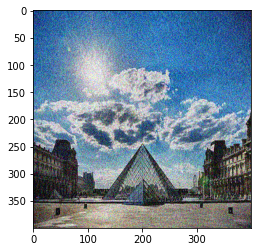

Epoch:  250


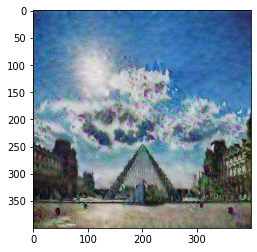

Epoch:  500


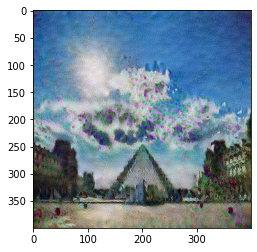

Epoch:  750


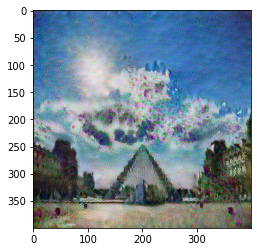

Epoch:  1000


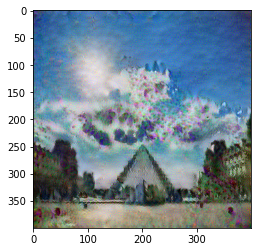

Epoch:  1250


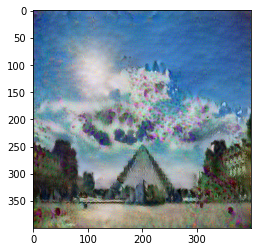

Epoch:  1500


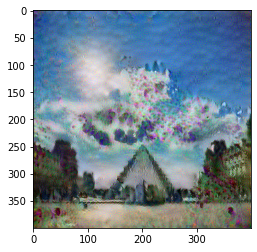

Epoch:  1750


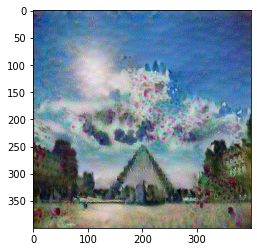

Epoch:  2000


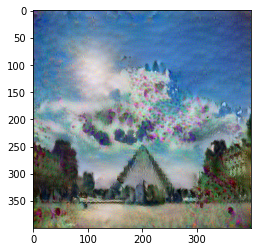

Epoch:  2250


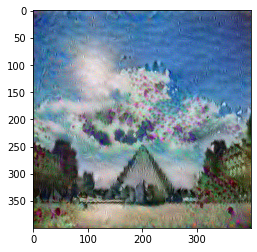

Epoch:  2500


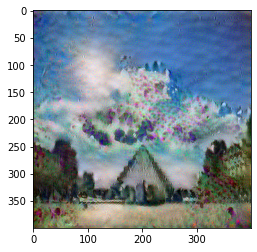

In [18]:
generated_image = tf.Variable(generated_image)
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print("Epoch: ", i)
        image = tensor_to_image(generated_image)
        plt.imshow(image)
        plt.show()

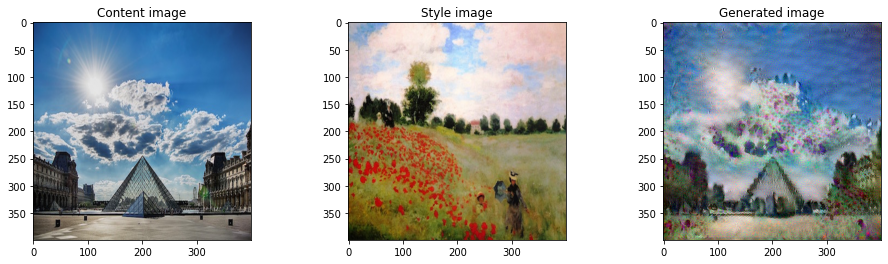

In [19]:
# Show the 3 images in a row
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(content_image[0])
plt.title('Content image')

plt.subplot(1, 3, 2)
plt.imshow(style_image[0])
plt.title('Style image')

plt.subplot(1, 3, 3)
plt.imshow(generated_image[0])
plt.title('Generated image')
plt.show()